In [236]:
import matplotlib.pyplot as plt
import math
import numpy as np

In [331]:
def Crank_Nicolson_Pricer(S0=91.9, T=457/365, r=0.0065246, dividend=0.047901, vol=0.55591, coupon=32.5,i_max = 457,j_max = 300):

    SU = 3 * S0  # Maximum price on the mesh
    SL = 0       # Minimum price on the mesh
    
    interest_barrier = 0.7 * S0  # The interest_barrier price that triggers the coupon
    
    dt = T/i_max  # Single movement on T-axis
    ds = (SU-SL)/j_max  # Single movement on S-axis
    
    S = np.arange(SL, SU+0.0001, SU/j_max)
    
    # trigger
    mesh_trigger = np.zeros((j_max+1, i_max+1))
    
    for j in range(0, j_max+1):  # Value at T
        if S[j] >= S0:
            mesh_trigger[j, i_max] = (1000+coupon)*math.exp(-r*5/365)
        elif S[j] >= interest_barrier:
            mesh_trigger[j, i_max] = (
                1000*S[j]/S0+coupon)*math.exp(-r*5/365)
        else:
            mesh_trigger[j, i_max] = (1000*S[j]/S0)*math.exp(-r*(5/365))
    
    j = np.arange(0, j_max+0.1, 1)  # 0 - jmax 共jmax+1个值
    
    a = [0.25*(vol**2*a**2-(r-dividend)*a) for a in j]
    a[0] = 0
    a[j_max] = 0
    
    b = [-vol**2*b**2/2-r/2-1/dt for b in j]
    b[0] = 1
    b[j_max] = 1
    
    c = [0.25*(vol**2*c**2+(r-dividend)*c) for c in j]
    c[0] = 0
    c[j_max] = 0
    
    alpha = [b[0]]*(j_max+1)
    for h in range(1, j_max+1):
        alpha[h] = b[h]-(a[h]*c[h-1])/alpha[h-1]
    
    for i in range(i_max-1, -1, -1): # t

        d = [0]*(j_max+1) # right side
        for m in range(1, j_max):
            d[m] = -a[m]*mesh_trigger[m-1, i+1] - (-vol**2*m**2/2-r/2+1/dt) * mesh_trigger[m, i+1]-c[m]*mesh_trigger[m+1, i+1]
        
        # up boundary 
        if i <= 95*int(i_max/457):
            mesh_trigger[j_max,i] = (1000+coupon)*math.exp(-r*(189*int(i_max/457)-i)/(365*int(i_max/457)))+coupon*math.exp(-r*(95*int(i_max/457)-i)/(365*int(i_max/457)))
        elif i <= 189*int(i_max/457):
            mesh_trigger[j_max,i] = (1000+coupon)*math.exp(-r*(189*int(i_max/457)-i)/(365*int(i_max/457)))
        elif i <= 281*int(i_max/457):
            mesh_trigger[j_max,i] = (1000+coupon)*math.exp(-r*(281*int(i_max/457)-i)/(365*int(i_max/457)))
        elif i <= 368*int(i_max/457):
            mesh_trigger[j_max,i] = (1000+coupon)*math.exp(-r*(368*int(i_max/457)-i)/(365*int(i_max/457)))
        else:
            mesh_trigger[j_max,i] = (1000+coupon)*math.exp(-r*(462*int(i_max/457)-i)/(365*int(i_max/457)))
        
        # low boundary
        mesh_trigger[0,i] = 0
        
        # LU Decomposition
        q = [mesh_trigger[0,i]]*(j_max+1)
        for u in range(1, j_max+1):
            q[u] = d[u]-q[u-1]*a[u]/alpha[u-1]

        mesh_trigger[j_max, i] = q[j_max]/alpha[j_max]
        for j in range(j_max-1, -1, -1):
            mesh_trigger[j, i] = (q[j]-c[j] * mesh_trigger[j+1, i])/alpha[j]
            
        if (i == 92*int(i_max/457)): # coupon date
            for j in range(0, j_max+1):
                if S[j] >= interest_barrier:
                    mesh_trigger[j, i] = mesh_trigger[j, i] + coupon*math.exp(-r*3/365)
                else:
                    continue
        
        if (i == 184*int(i_max/457)):
            for j in range(int(j_max/3*0.7), j_max+1):
                if S[j] >= S0:
                    mesh_trigger[j, i] = (1000+coupon)*math.exp(-r*5/365)
                elif S[j] >= interest_barrier:
                    mesh_trigger[j, i] = mesh_trigger[j, i]+coupon*math.exp(-r*5/365)
                else:
                    continue

        if (i == 275*int(i_max/457)):
            for j in range(int(j_max/3*0.7), j_max+1):
                if S[j] >= S0:
                    mesh_trigger[j, i] = (1000+coupon)*math.exp(-r*6/365)
                elif S[j] >= interest_barrier:
                    mesh_trigger[j, i] = mesh_trigger[j, i]+coupon*math.exp(-r*6/365)
                else:
                    continue
                    
        if (i == 365*int(i_max/457)):
            for j in range(int(j_max/3*0.7), j_max+1):
                if S[j] >= S0:
                    mesh_trigger[j, i] = (1000+coupon)*math.exp(-r*3/365)
                elif S[j] >= interest_barrier:
                    mesh_trigger[j, i] = mesh_trigger[j, i]+coupon*math.exp(-r*3/365)
                else:
                    continue

        else:
            continue
    
    # without trigger
    mesh_not_trigger = np.zeros((j_max+1, i_max+1)) 
    for j in range(int(j_max/3*0.7), j_max+1):  # Value at T
        mesh_not_trigger[j, i_max] = (1000+coupon)*math.exp(-r*5/365)
    for j in range(0, int(j_max/3*0.7)):
        mesh_not_trigger[j, i_max] = mesh_trigger[j, i_max]

    j = np.arange(0, j_max+0.1, 1)  # 0 - jmax 共jmax+1个值
    
    a = [0.25*(vol**2*a**2-(r-dividend)*a) for a in j]
    a[int(j_max/3*0.7)] = 0
    a[j_max] = 0
    
    b = [-vol**2*b**2/2-r/2-1/dt for b in j]
    b[int(j_max/3*0.7)] = 1
    b[j_max] = 1
    
    c = [0.25*(vol**2*c**2+(r-dividend)*c) for c in j]
    c[int(j_max/3*0.7)] = 0
    c[j_max] = 0
    
    alpha = [b[int(j_max/3*0.7)]]*(j_max+1)
    for h in range(int(j_max/3*0.7)+1, j_max+1):
        alpha[h] = b[h]-(a[h]*c[h-1])/alpha[h-1]        

    for i in range(i_max-1, -1, -1): # t
            
        d = [0]*(j_max+1) # right side
        for m in range(int(j_max/3*0.7), j_max):
            d[m] = -a[m]*mesh_not_trigger[m-1, i+1] - (-vol**2*m**2/2-r/2+1/dt) * mesh_not_trigger[m, i+1]-c[m]*mesh_not_trigger[m+1, i+1]
        
        # up boundary 
        if i <= 95*int(i_max/457):
            mesh_not_trigger[j_max,i] = (1000+coupon)*math.exp(-r*(189*int(i_max/457)-i)/(365*int(i_max/457)))+coupon*math.exp(-r*(95*int(i_max/457)-i)/(365*int(i_max/457)))
        elif i <= 189*int(i_max/457):
            mesh_not_trigger[j_max,i] = (1000+coupon)*math.exp(-r*(189*int(i_max/457)-i)/(365*int(i_max/457)))
        elif i <= 281*int(i_max/457):
            mesh_not_trigger[j_max,i] = (1000+coupon)*math.exp(-r*(281*int(i_max/457)-i)/(365*int(i_max/457)))
        elif i <= 368*int(i_max/457):
            mesh_not_trigger[j_max,i] = (1000+coupon)*math.exp(-r*(368*int(i_max/457)-i)/(365*int(i_max/457)))
        else:
            mesh_not_trigger[j_max,i] = (1000+coupon)*math.exp(-r*(462*int(i_max/457)-i)/(365*int(i_max/457)))
        
        # low boundary
        mesh_not_trigger[int(j_max/3*0.7),i] = mesh_trigger[int(j_max/3*0.7), i]
            
        # LU Decomposition
        q = [mesh_not_trigger[int(j_max/3*0.7),i]]*(j_max+1)
        for u in range(int(j_max/3*0.7)+1, j_max+1):
            q[u] = d[u]-q[u-1]*a[u]/alpha[u-1]    
            
        mesh_not_trigger[j_max, i] = q[j_max]/alpha[j_max]
        for j in range(j_max-1, int(j_max/3*0.7)-1, -1):
            mesh_not_trigger[j, i] = (q[j]-c[j]*mesh_not_trigger[j+1, i])/alpha[j]

        if (i == 92*int(i_max/457)): # coupon date
            for j in range(int(j_max/3*0.7), j_max+1):
                if S[j] >= interest_barrier:
                    mesh_not_trigger[j, i] = mesh_not_trigger[j, i]+coupon*math.exp(-r*3/365)
                else:
                    continue
                        
        if (i == 184*int(i_max/457)):
            for j in range(int(j_max/3*0.7), j_max+1):
                if S[j] >= S0:
                    mesh_not_trigger[j, i] = (1000+coupon)*math.exp(-r*5/365)
                elif S[j] >= interest_barrier:
                    mesh_not_trigger[j, i] = mesh_not_trigger[j, i]+coupon*math.exp(-r*5/365)
                else:
                    continue

        if (i == 275*int(i_max/457)):
            for j in range(int(j_max/3*0.7), j_max+1):
                if S[j] >= S0:
                    mesh_not_trigger[j, i] = (1000+coupon)*math.exp(-r*6/365)
                elif S[j] >= interest_barrier:
                    mesh_not_trigger[j, i] = mesh_not_trigger[j, i]+coupon*math.exp(-r*6/365)
                else:
                    continue
                    
        if (i == 365*int(i_max/457)):
            for j in range(int(j_max/3*0.7), j_max+1):
                if S[j] >= S0:
                    mesh_not_trigger[j, i] = (1000+coupon)*math.exp(-r*3/365)
                elif S[j] >= interest_barrier:
                    mesh_not_trigger[j, i] = mesh_not_trigger[j, i]+coupon*math.exp(-r*3/365)
                else:
                    continue
                    
        else:
            continue
    return(mesh_not_trigger[int(j_max/3),0])  

In [332]:
value=Crank_Nicolson_Pricer()
value

859.9359934075096

In [333]:
value=[]
for i in np.arange(0.45116,0.55591,0.01000):
    value.append(Crank_Nicolson_Pricer(vol=i))
print(value)

[905.2895389236793, 900.920291461191, 896.5755989314956, 892.2491027219, 887.9347700338178, 883.6268989948496, 879.3201246786524, 875.0094250857505, 870.6901262860619, 866.3579060964565, 862.0087958456252]


In [334]:
np.arange(0.45116,0.55591,0.01000)


array([0.45116, 0.46116, 0.47116, 0.48116, 0.49116, 0.50116, 0.51116,
       0.52116, 0.53116, 0.54116, 0.55116])

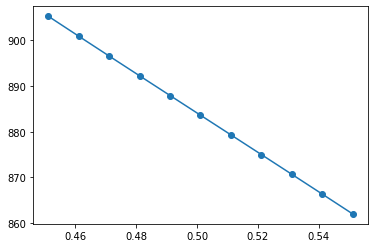

In [335]:
plt.plot(np.arange(0.45116,0.55591,0.01000),value,linestyle='-',marker='o')

In [336]:
value2=[]
for j in np.arange(300,3001,300):
    value2.append(Crank_Nicolson_Pricer(j_max = j))

In [340]:
print(value2)

[859.9359934075096, 859.1625479855596, 859.0063986256266, 859.7669783783052, 861.61962592848, 863.9818217019579, 866.2350181549999, 868.5860315917766, 870.5595709215969, 872.2985781829526]


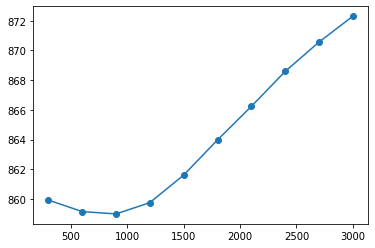

In [341]:
plt.plot(np.arange(300,3001,300),value2,linestyle='-',marker='o')

In [339]:
value3=[]
for i in np.arange(457,4571,457):
    value3.append(Crank_Nicolson_Pricer(i_max = i))

In [342]:
print(value3)

[859.9359934075096, 859.8345824145885, 859.8007425736462, 859.7838158349932, 859.7736576054682, 859.7668845404291, 859.7620461898157, 859.7584171822078, 859.7555944757705, 859.7533362192243]


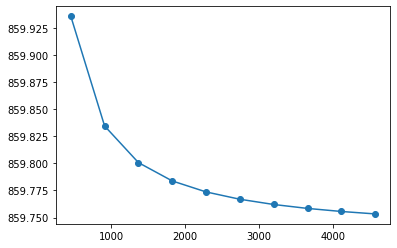

In [343]:
plt.plot(np.arange(457,4571,457),value3,linestyle='-',marker='o')